In [11]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Listing current data on our folder.
import os

In [12]:
import wget


midi_path = "MIDIs"
sonic_folder = "sonic"

#!rm -r $midi_path
#!mkdir $midi_path

# Some helper methods.    
def concat_path(path, child):
    return path + "/" + child

def download_midi(midi_url, path):

    filename= wget.download(midi_url,path) 
    filename
    
# Downloading an example file.
sonic_path = concat_path(midi_path, sonic_folder)
download_midi(
    "https://files.khinsider.com/midifiles/genesis/sonic-the-hedgehog/green-hill-zone.mid",
    sonic_path)
    
print(os.listdir(sonic_path))

100% [..............................................................................] 13034 / 13034['green-hill-zone (1).mid', 'green-hill-zone.mid', 'sonic1', 'sonic2', 'sonic3', 'sonicAndKnuckles', '_DS_Store']


In [15]:
from music21 import converter, corpus, instrument, midi, note, chord, pitch
def open_midi(midi_path, remove_drums):
    # There is an one-line method to read MIDIs
    # but to remove the drums we need to manipulate some
    # low level MIDI events.
    mf = midi.MidiFile()
    mf.open(midi_path)
    mf.read()
    mf.close()
    if (remove_drums):
        for i in range(len(mf.tracks)):
            mf.tracks[i].events = [ev for ev in mf.tracks[i].events if ev.channel != 10]          

    return midi.translate.midiFileToStream(mf)
    
base_midi = open_midi(concat_path(sonic_path, "green-hill-zone.mid"), True)
base_midi

<music21.stream.Score 0x285172f9400>

[]
[50.0, 66.0, 62.0, 57.0, 55.0, 66.0, 66.0, 55.0, 50.0, 66.0, 62.0, 57.0, 55.0, 66.0, 66.0, 55.0, 60.0, 71.0, 71.0, 71.0, 60.0, 67.0, 71.0]


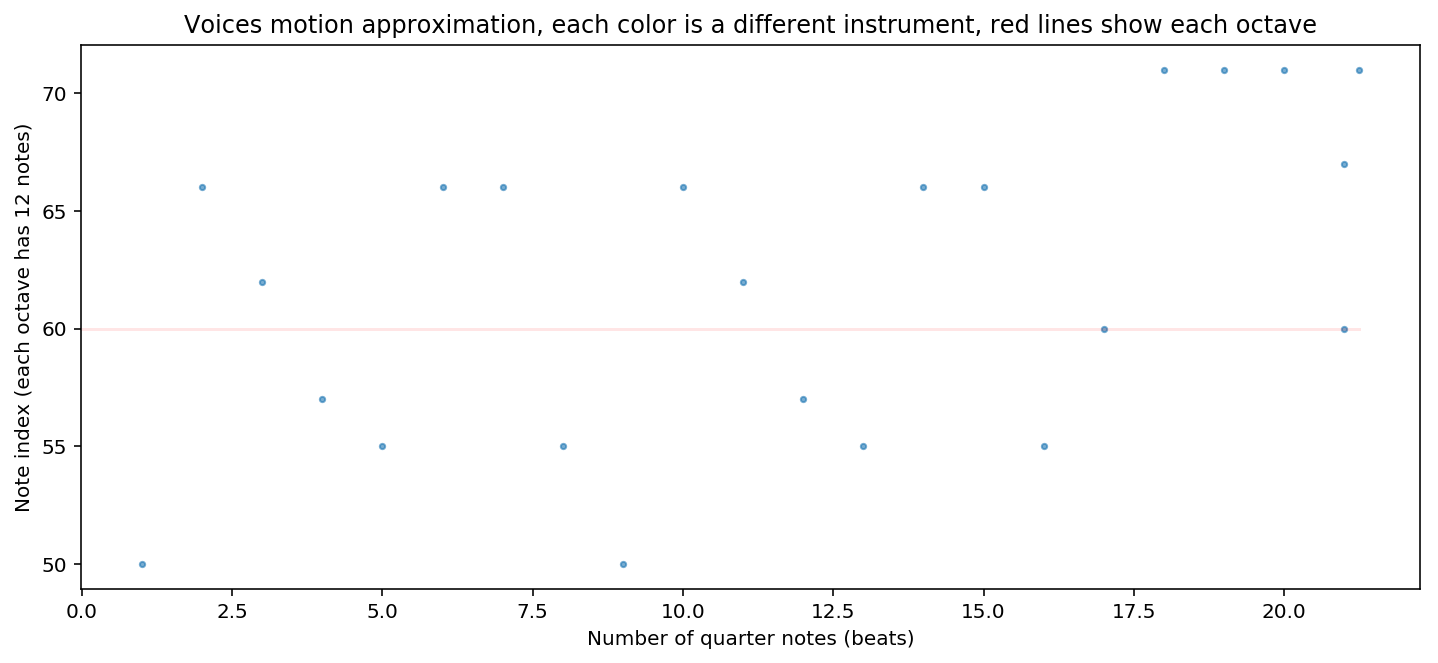

In [18]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

def extract_notes(midi_part):
    parent_element = []
    ret = []
    for nt in midi_part.flat.notes:        
        if isinstance(nt, note.Note):
            ret.append(max(0.0, nt.pitch.ps))
            parent_element.append(nt)
        elif isinstance(nt, chord.Chord):
            for pitch in nt.pitches:
                ret.append(max(0.0, pitch.ps))
                parent_element.append(nt)
    print(ret)
    return ret, parent_element

def print_parts_countour(midi):
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(1, 1, 1)
    minPitch = pitch.Pitch('C10').ps
    maxPitch = 0
    xMax = 0
    
    # Drawing notes.
    for i in range(len(midi.parts)):
        top = midi.parts[i].flat.notes                  
        y, parent_element = extract_notes(top)
        if (len(y) < 1): continue
            
        x = [n.offset for n in parent_element]
        ax.scatter(x, y, alpha=0.6, s=7)
        
        aux = min(y)
        if (aux < minPitch): minPitch = aux
            
        aux = max(y)
        if (aux > maxPitch): maxPitch = aux
            
        aux = max(x)
        if (aux > xMax): xMax = aux
    
    for i in range(1, 10):
        linePitch = pitch.Pitch('C{0}'.format(i)).ps
        if (linePitch > minPitch and linePitch < maxPitch):
            ax.add_line(mlines.Line2D([0, xMax], [linePitch, linePitch], color='red', alpha=0.1))            

    plt.ylabel("Note index (each octave has 12 notes)")
    plt.xlabel("Number of quarter notes (beats)")
    plt.title('Voices motion approximation, each color is a different instrument, red lines show each octave')
    plt.show()

# Focusing only on 6 first measures to make it easier to understand.
print_parts_countour(base_midi.measures(0, 6))


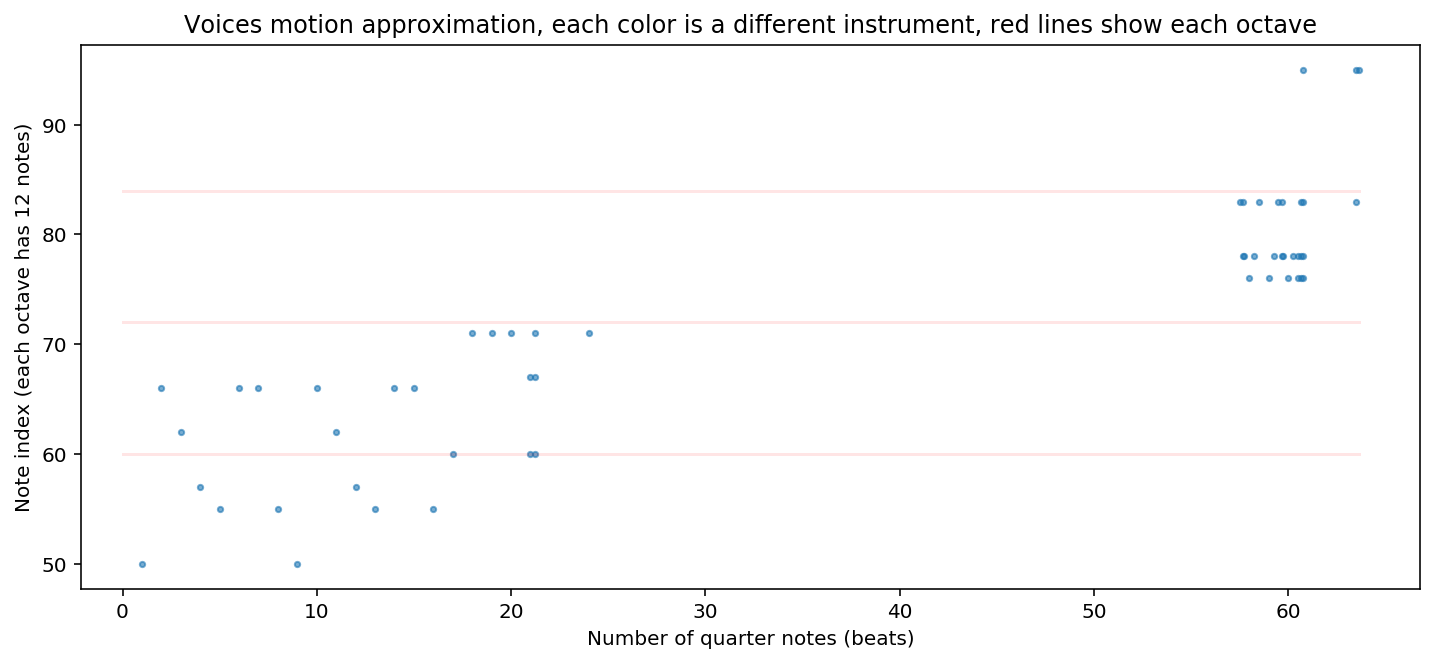

{0.0} <music21.stream.Measure 1 offset=0.0>
    {0.0} <music21.clef.TrebleClef>
    {0.0} <music21.meter.TimeSignature 4/4>
    {0.0} <music21.note.Rest rest>
    {1.0} <music21.chord.Chord D3>
    {2.0} <music21.chord.Chord F#4>
    {3.0} <music21.chord.Chord D4>


In [17]:
from music21 import stream

temp_midi_chords = open_midi(
    concat_path(sonic_path, "green-hill-zone.mid"),
    True).chordify()
temp_midi = stream.Score()
temp_midi.insert(0, temp_midi_chords)

# Printing merged tracks.
print_parts_countour(temp_midi)

# Dumping first measure notes
temp_midi_chords.measures(0, 1).show("text")

In [6]:
from music21 import roman

def note_count(measure, count_dict):
    bass_note = None
    for chord in measure.recurse().getElementsByClass('Chord'):
        # All notes have the same length of its chord parent.
        note_length = chord.quarterLength
        for note in chord.pitches:          
            # If note is "C5", note.name is "C". We use "C5"
            # style to be able to detect more precise inversions.
            note_name = str(note) 
            if (bass_note is None or bass_note.ps > note.ps):
                bass_note = note
                
            if note_name in count_dict:
                count_dict[note_name] += note_length
            else:
                count_dict[note_name] = note_length
        
    return bass_note
                
def simplify_roman_name(roman_numeral):
    # Chords can get nasty names as "bII#86#6#5",
    # in this method we try to simplify names, even if it ends in
    # a different chord to reduce the chord vocabulary and display
    # chord function clearer.
    ret = roman_numeral.romanNumeral
    inversion_name = None
    inversion = roman_numeral.inversion()
    
    # Checking valid inversions.
    if ((roman_numeral.isTriad() and inversion < 3) or
            (inversion < 4 and
                 (roman_numeral.seventh is not None or roman_numeral.isSeventh()))):
        inversion_name = roman_numeral.inversionName()
        
    if (inversion_name is not None):
        ret = ret + str(inversion_name)
        
    elif (roman_numeral.isDominantSeventh()): ret = ret + "M7"
    elif (roman_numeral.isDiminishedSeventh()): ret = ret + "o7"
    return ret
                
def harmonic_reduction(midi_file):
    ret = []
    temp_midi = stream.Score()
    temp_midi_chords = midi_file.chordify()
    temp_midi.insert(0, temp_midi_chords)    
    music_key = temp_midi.analyze('key')
    max_notes_per_chord = 4   
    for m in temp_midi_chords.measures(0, None): # None = get all measures.
        if (type(m) != stream.Measure):
            continue
        
        # Here we count all notes length in each measure,
        # get the most frequent ones and try to create a chord with them.
        count_dict = dict()
        bass_note = note_count(m, count_dict)
        if (len(count_dict) < 1):
            ret.append("-") # Empty measure
            continue
        
        sorted_items = sorted(count_dict.items(), key=lambda x:x[1])
        sorted_notes = [item[0] for item in sorted_items[-max_notes_per_chord:]]
        measure_chord = chord.Chord(sorted_notes)
        
        # Convert the chord to the functional roman representation
        # to make its information independent of the music key.
        roman_numeral = roman.romanNumeralFromChord(measure_chord, music_key)
        ret.append(simplify_roman_name(roman_numeral))
        
    return ret

harmonic_reduction(base_midi)[0:10]

['-VII', 'ii', 'iii43', 'ii', 'vi43', 'vi7', 'v', '-', '-', '-']

In [7]:
import requests
from bs4 import BeautifulSoup

def get_file_name(link):
    filename = link.split('/')[::-1][0]
    return filename


def download_file(link, filename):
    mid_file_request = requests.get(link, stream=True)
    if (mid_file_request.status_code != 200):
        raise Exception("Failed to download {0}".format(url))
        
    with open(filename, 'wb+') as saveMidFile:
        saveMidFile.write(mid_file_request.content)

def download_midi_files(url, output_path):
    site_request = requests.get(url)
    if (site_request.status_code != 200):
        raise Exception("Failed to access {0}".format(url))
    
    soup = BeautifulSoup(site_request.content, 'html.parser')
    link_urls = soup.find_all('a')

    for link in link_urls:
        href = link['href']
        if (href.endswith(".mid")):
            file_name = get_file_name(href)
            download_path = concat_path(output_path, file_name)
            midi_request = download_file(href, download_path)

def start_midis_download(folder, url):
    !mkdir $folder # It is fine if this command fails when the directory already exists.
    download_midi_files(url, folder)

target_games = dict()
target_games["sonic1"] = "https://www.khinsider.com/midi/genesis/sonic-the-hedgehog"
target_games["sonic2"] = "https://www.khinsider.com/midi/genesis/sonic-the-hedgehog-2"
target_games["sonic3"] = "https://www.khinsider.com/midi/genesis/sonic-the-hedgehog-3"
target_games["sonicAndKnuckles"] = "https://www.khinsider.com/midi/genesis/sonic-and-knuckles"

for key, value in target_games.items():
    file_path = concat_path(sonic_path, key)
    start_midis_download(file_path, value)

The syntax of the command is incorrect.


KeyboardInterrupt: 

In [7]:
# from multiprocessing import Pool # Use this when CPU-intensive functions are the problem.

def get_file_name(midip):
    filename = midip.split('/')[::-1][0]
    return filename


target_games = dict()
target_games["sonic1"] = "https://www.khinsider.com/midi/genesis/sonic-the-hedgehog"
target_games["sonic2"] = "https://www.khinsider.com/midi/genesis/sonic-the-hedgehog-2"
target_games["sonic3"] = "https://www.khinsider.com/midi/genesis/sonic-the-hedgehog-3"
target_games["sonicAndKnuckles"] = "https://www.khinsider.com/midi/genesis/sonic-and-knuckles"

# Go get a coffee, this cell takes hours to run...
def process_single_file(midi_param):
    try:
        game_name = midi_param[0]
        midi_path = midi_param[1]
        midi_name = get_file_name(midi_path)
        print(midi_name)
        
        midi = open_midi(midi_path, True)
        return (
            midi.analyze('key'),
            game_name,
            harmonic_reduction(midi),
            midi_name)
    except Exception as e:
        print("Error on {0}".format( get_file_name(midi_path)))
        print(e)
        return None

def create_midi_dataframe(target_games):
    key_signature_column = []
    game_name_column = []
    harmonic_reduction_column = []
    midi_name_column = []
    #pool = Pool(8)
    midi_params = []
    i=0
    for key, value in target_games.items():
        folder_path = concat_path(sonic_path, key)
        for midi_name in os.listdir(folder_path):
            midi_params.append((key, concat_path(folder_path, midi_name)))
            #print(midi_params)   
            result = process_single_file((key, concat_path(folder_path, midi_name)))
            
            if (result is None):
                continue
        
            key_signature_column.append(result[0])
            game_name_column.append(result[1])
            harmonic_reduction_column.append(result[2])
            midi_name_column.append(result[3])
    
    d = {'midi_name': midi_name_column,
         'game_name': game_name_column,
         'key_signature' : key_signature_column,
         'harmonic_reduction': harmonic_reduction_column}
    return pd.DataFrame(data=d)

sonic_df = create_midi_dataframe(target_games)


009count.mid
040 Feat Erica Baxter - Dreams (Lost Witness Remix).mid
040FeatEricaBaxter_-_DreamsLostWitnessRemix__SamCera_20120708165703.mid
050620B (The Children of the Night).MID
051230.MID
060107-Sonnet 73.MID
060222-Tribute to Mozart.MID
070102 (I'll Love You Always).MID
070107 (Music of the Third Kind).MID
070110 (The Raven Days).MID
070527 (Oh for a Poet).MID
070606 (Hail the Comic Song).MID
09carnivalcuckoo.mid
1,000MoreFools.mid
1-01-Prelude-Xg.mid
1-01_Prelude_Awe.mid
1-02-Opening-Xg.mid
1-04-Anxious-Heart-Xg.mid
1-05-Tifas-Theme-Xg.mid
1-06_Baretts_Theme_Awe.mid
1-07_Hurry_Awe.mid
1-09-ShinRa-Company-Xg.mid
1-09_ShinRa_Company_Awe.mid
1-10-Fighting-Xg.mid
1-11_Fanfare_Awe.mid
1-13-Turks-Theme-Xg.mid
1-13kb.mid
1-17_Who_Are_You_Awe.mid
1-2-3-4--Sumpin'-New.mid
1-2-3.mid
1-2-3_ngoi_sao.mid
1-21-Red-XIII-Theme-Xg.mid
1-21_Red_XIIIs_Theme_Awe.mid
1-3.mid
1-4.mid
1-5.mid
1-6.mid
1-7.mid
1-8.mid
1-letthegoodtimesroll.mid
1.MID
10,000Promises.mid
10,000Years.mid
10-7kb.mid
10-STRAN.

Error on 16cndls.mid
cannot place element <music21.tempo.MetronomeMark largamente Quarter=30.0> with start/end 216.0/216.0 within any measures
16flens.mid
16gicru.mid
16gumar.mid
16gunin.mid
16guojo.mid
16moeme.mid
16mopec.mid
16mufan.mid
16mugal.mid
16mulud.mid
16murec.mid
16nabax.mid
16naemp.mid
16navac.mid
16orfel.mid
16orre1.mid
Error on 16orre1.mid
cannot place element <music21.tempo.MetronomeMark vivacissimo Quarter=170.0> with start/end 228.0/228.0 within any measures
16orre5.mid
16orre8.mid
16pipav.mid
16restawhile.mid
16roreg.mid
16samu1.mid
16samu2.mid
16SOMEWH.MID
16SWBLUE.MID
16vasie.mid
16velib.mid
16viave.mid
16vimag.mid
16viqua.mid
16WFDEBI.MID
16_Bit_Lolitas_feat_Jennifer_Horne_-_Nobody_Seems_To_Care___lookitselmo_20100122121126.mid
Error on 16_Bit_Lolitas_feat_Jennifer_Horne_-_Nobody_Seems_To_Care___lookitselmo_20100122121126.mid
cannot place element Piano with start/end 32.0/32.0 within any measures
17.mid
1703.mid
170SANFR.MID
Error on 170SANFR.MID
#- is not a suppor

a-espa.mid
a-fabio.mid
A-Far-L'amore.mid
a-fernando.mid
A-Fine-Romance-(From-'A-Fine-Romance').mid
A-Foggy-Day-(Jazz-Gitaar-Trio).mid
A-Foggy-Day.mid
a-fpp.mid
A-Getting-Sentimental-Over-You-1.mid
a-ghost.mid
A-Girl-Like-You.mid
A-Glass-Of-Champagne.mid
A-Good-Heart.mid
A-Groovy-Kind-Of-Love-1.mid
A-Groovy-Kind-Of-Love-2.mid
A-Groovy-Kind-Of-Love.mid
A-Haep-See-But-A-Few-Know.mid
A-Hard-Day's-Night-1.mid
A-Hard-Day's-Night-2.mid
A-Hard-Day's-Night-3.mid
A-Hard-Day's-Night-4.mid
A-Hard-Day's-Night-5.mid
A-Hirten.mid
A-Horse-With-No-Name-2.mid
a-ilove.mid
a-ioche.mid
A-Kind-Of-Magic-1.mid
A-Kind-Of-Magic-2.mid
A-Kind-Of-Magic-3.mid
A-La-Francaise.mid
A-Little-Bit-More-1.mid
A-Little-Bit-More-2.mid
A-Little-Less-Talk-And-A-Lot-More-Action.mid
A-Little-Respect.mid
A-Little-To-Late.mid
A-Love-Song.mid
A-Lusion & Scope DJ - Between Worlds.mid
Error on A-Lusion & Scope DJ - Between Worlds.mid
cannot place element  with start/end 64.0/64.0 within any measures
A-Lusion & Scope Dj - Reaching Out

aaron_carter-saturday_night.mid
Aaron_Neville_-_Tell_It_Like_It_Is.mid
aatbak1.mid
aatbak2.mid
aatenni.mid
aatime4us.mid
AATW_REP.MID
Aavakts.mid
aayel.mid
ab-domino_waltz.mid
ab-oborvannyie_struny.mid
ab-phantomoftheopera.mid
ab.mid
ab03.mid
ab04.mid
ab05.mid
Error on ab05.mid
badly formed midi string: missing leading MTrk
ab09.mid
ab2.mid
ab22.mid
Aba-Heidschi-Bumbeidschi.mid
Abacab-2.mid
Abacab.mid
ABACAB2.MID
Abadgood.mid
abadgoodbye.mid
abamoney.mid
abarajame.mid
abarbaro.mid
Error on abarbaro.mid
cannot place element C major with start/end 454.0/454.0 within any measures
Abarrach.mid
aba_father.mid
abba-dancing_queen.mid
abba-does_your_mother_know.mid
Abba-Esque.mid
Error on Abba-Esque.mid
#- is not a supported accidental type
abba-fernando.mid
abba-hamlet_iii.mid
abba-i_am_the_city.mid
abba-i_have_a_dream.mid
abba-just_like_that.mid
Error on abba-just_like_that.mid
badly formed midi string: missing leading MTrk
abba-knowing_me_knowing_you.mid
ABBA-Lay_all_your_love_on_me.mid
Abb

Above & Beyond Feat Kate Cameron - Far From In Love San Francisco Mix.mid
Above & Beyond Feat Richard Bedford - Every Little Beat.mid
Error on Above & Beyond Feat Richard Bedford - Every Little Beat.mid
cannot place element Guitar with start/end 192.0/192.0 within any measures
Above & Beyond Feat Zoe Johnston - No One On Earth Above & Beyonds San Francisco Mix.mid
Above & Beyond Pres.Oceanlab - Lonely Girl (Gareth Emery Mix).mid
Above & Beyond presents Tranquility Base - Oceanic.mid
Error on Above & Beyond presents Tranquility Base - Oceanic.mid
cannot place element Piano with start/end 32.0/32.0 within any measures
Above & Beyond vs. Andy Moor - Air For Life (Original Mix).mid
above.mid
AboveBeyondFeatKateCameron_-_FarFromInLoveSanFranciscoMix__Zoik_20121210230030.mid
AboveBeyondFeatZoeJohnston_-_NoOneOnEarthAboveBeyondsSanFranciscoMix__Zoik_20121210223928.mid
AboveBeyondPresOceanlab_-_LonelyGirlGarethEmeryMix__mostafaomar77_20130206062408.mid
AboveBeyond_-_Eternal__MarinKaracic_20120

ac-togetheragain.mid
ac01.mid
ACACIAAVE.MID
ACACIAS.MID
Error on ACACIAS.MID
badly formated midi bytes, got: b''
academia.mid
acadian.mid
acai.mid
ACalmSea.mid
AcapulcoHeat.mid
Acariciame-Sei-Bellisima.mid
acasa.mid
acasado.mid
acbeauty.mid
Accadia - Blind Visions (Accadia Ambient Mix).mid
Accadia - Blind Visions.mid
Accadia - Into The Dawn.mid
accadia__blind_visions__accadia_ambient_mix__zoik.mid
accadia__blind_visions__john_steenbergen.mid
accadia__into_the_dawn__bren-f.mid
Accarezzame.mid
acceleration.mid
accept.mid
Access 3 - Promised Land (Squad-E Remix).mid
Access_3_-_Promised_Land_(Squad-E_Remix)__Remane_20111015055901.mid
AccidentalTourist.mid
Accordeon-Polka.mid
accordeon.mid
Accrossuniv.mid
Accuface - Anything is Possible.mid
Accuface - Let Your Mind Fly 2007.mid
Accuface - Space Is The Place.mid
Accuface - Travelling Without Moving.mid
Accuface_-_Anything_is_Possible__AniG_20061223092439.mid
Accuface_-_Anything_is_Possible__Ertais_20070202003821.mid
Accuface_-_Let_Your_Mind_

activeh.mid
Activex.mid
active_sight__adrenalin__syndrome_edit__mpalpha.mid
Error on active_sight__adrenalin__syndrome_edit__mpalpha.mid
cannot place element Piano with start/end 196.0/196.0 within any measures
active_sight__out_of_our_lives__zoik.mid
Error on active_sight__out_of_our_lives__zoik.mid
cannot place element  with start/end 68.0/68.0 within any measures
active_sight__the_search_for_freedom__john_steenbergen.mid
Acti_-_Crap_Out__Jumpy_20080301213943.mid
Error on Acti_-_Crap_Out__Jumpy_20080301213943.mid
cannot place element Piano with start/end 32.0/32.0 within any measures
Acti_and_Coca_-_Fuck_With_The_Beatz__Hudman_20070525130641.mid
Error on Acti_and_Coca_-_Fuck_With_The_Beatz__Hudman_20070525130641.mid
cannot place element Piano with start/end 32.0/32.0 within any measures
Acti__Coca_-_Old_Rulez__Muller_20070310163436.mid
ActNaturally4.mid
actor.mid
actorremix.mid
actraiser-end.mid
actress.mid
acttrag.mid
act_naturally.mid
Acues & Elitist - Zonderland.mid
Acues__Elitist

adele-cold_shoulder.mid
adele-crazy_for_you.mid
adele-daydreamer.mid
adele-dont_you_remember.mid
adele-first_love.mid
adele-he_wont_go.mid
adele-hometown_glory.mid
adele-ill_be_waiting.mid
adele-lovesong.mid
adele-make_you_feel_my_love.mid
adele-melt_my_heart_to_stone.mid
adele-my_same.mid
adele-one_and_only.mid
adele-right_as_rain.mid
adele-rolling_in_the_deep.mid
adele-rolling_in_the_deep_version_2.mid
adele-rumour_has_it.mid
adele-set_fire_to_the_rain.mid
adele-skyfall.mid
adele-skyfall_version_2.mid
adele-skyfall_version_3.mid
adele-someone_like_you.mid
adele-someone_like_you_version_2.mid
adele-take_it_all.mid
adele-turning_tables.mid
Adele_-_First_Love__John_20080826011651.mid
adele_-_hometown_glory_free_midi.mid
Adele_-_Hometown_Glory__John_20091219161011.mid
Adele_-_RollingInTheDeep__Intricacy_20120311183229.mid
Adele_-_Skyfall__tomnucleus_20121210233914.mid
Adelheid-(Gartenzwergmarsch).mid
Adelheid-Medley-(Medley).mid
ADELINA.mid
ADELINE.MID
adeline2.mid
adelita.mid
ADEMNOOD.M

afrikastart001.mid
afripolc.mid
AfriUnit.mid
afrocub2.mid
Error on afrocub2.mid
list index out of range
Afrojack - Ghettoblaster.mid
Error on Afrojack - Ghettoblaster.mid
cannot place element Piano with start/end 8.0/8.0 within any measures
Afrojack ft Eva Simons - Take Over Control.mid
Afrojack ft. Shermanology - Can't Stop Me Now.mid
Afrojack ft. Shermanology - Can't Stop Me.mid
Error on Afrojack ft. Shermanology - Can't Stop Me.mid
cannot place element  with start/end 32.0/32.0 within any measures
Afrojack ft. The Partysquad - Drop Down.mid
Error on Afrojack ft. The Partysquad - Drop Down.mid
cannot place element Piano with start/end 8.0/8.0 within any measures
AfrojackftShermanology_-_CantStopMeNowversion2__cobrarecords_20130131213756.mid
AfrojackftShermanology_-_CantStopMeNowversion3__Viktorious_20130131213818.mid
Error on AfrojackftShermanology_-_CantStopMeNowversion3__Viktorious_20130131213818.mid
cannot place element  with start/end 32.0/32.0 within any measures
AfrojackftSherm

ahrobingentlerobinuntitled.mid
ahundredmiles.mid
Ai-No-Senshi.mid
ai-siang-sui.mid
ai.mid
ai2.mid
aicha.mid
aida.mid
aida1.mid
AIDAMARC.MID
aida_ii2.mid
aida_ovt.mid
Aidemoi.mid
aidezhenghaoremix.mid
Aiera_-_DunesAhmedRomelRemix__TM46_20130211014156.mid
aigaian.mid
aigaioy.mid
aight.mid
Error on aight.mid
badly formed midi string: missing leading MTrk
aikendrm.mid
aikotoba.mid
AiKotobaWaMoonPrismPowerMakeUp2.mid
Ail.mid
ailh.mid
ailif.mid
aimer.mid
Ain't-Going-Down-Till-The-Sun-Comes-Up.mid
Ain't-Misbehavin'.mid
Ain't-No-Doubt.mid
Ain't-No-Mountain-High-Enough.mid
Ain't-No-Sunshine.mid
Ain't-Nobody.mid
Ain't-Nothing-Wrong-With-The-Radio.mid
Ain't-That-A-Lot-Of-love.mid
Ain't-That-Lonely-Yet.mid
Ain't-Too-Proud-To-Beg-1.mid
Ain't-Too-Proud-To-Beg-2.mid
Ain'tNoSunshine.mid
Ain'tSheSweet.mid
aindaec.mid
aindalembro.mid
aindalembro2.mid
ainian.mid
ainomama.mid
AiNoSenshi3.mid
AiNoSenshi4.mid
AiNoSenshi5.mid
AiNoSenshi6.mid
aint-misbehaving.mid
Aint-That-Just-The-Way.mid
aint.mid
aintgoin.m

Error on airforg2.mid
cannot place element <music21.tempo.MetronomeMark grave Quarter=40.0> with start/end 144.0/144.0 within any measures
airgm.mid
AIRHEAD.MID
airhors3.mid
airhorss.mid
airliner.mid
airman.mid
airnite2.mid
airnvari.mid
Airon.mid
Airplay - The Music Is Moving(Radio Edit).mid
Airplay_-_TheMusicIsMovingRadioEdit__DJTranceStorm_20121210235712.mid
Airscape - L'Esperanza.mid
Airscape - LEsperanza_1.mid
Error on Airscape - LEsperanza_1.mid
badly formated midi bytes, got: b'Rar!\x1a\x07\x00\xcf\x90s\x00\x00\r\x00\x00\x00\x00\x00\x00\x00'
Airscape - Sosei V2.mid
Error on Airscape - Sosei V2.mid
cannot place element  with start/end 64.0/64.0 within any measures
Airscape - Sosei.mid
Airscape_-_LEsperanza__Unknown_20121210235641.mid
Error on Airscape_-_LEsperanza__Unknown_20121210235641.mid
badly formated midi bytes, got: b'Rar!\x1a\x07\x00\xcf\x90s\x00\x00\r\x00\x00\x00\x00\x00\x00\x00'
airscape__l_esperanza__refraction.mid
airscape__sosei_v2__cloudburst.mid
Error on airscape_

alaniss-hand.mid
alanis_morissette-are_you_still_mad.mid
alanis_morissette-crazy.mid
alanis_morissette-dangerous.mid
alanis_morissette-guardian.mid
alanis_morissette-ironic.mid
alanis_morissette-joining_you.mid
alanis_morissette-mary_jane.mid
alanis_morissette-not_as_we.mid
alanis_morissette-offer.mid
alanis_morissette-out_is_through.mid
alanis_morissette-precious_illusions.mid
alanis_morissette-right_through_you.mid
alanis_morissette-thank_you.mid
alanis_morissette-that_i_would_be_good.mid
alanis_morissette-the_couch.mid
alanis_morissette-unsent.mid
alanis_morissette-utopia.mid
alanis_morissette-you_ought_to_know.mid
Alanis_Morissette_Hand_in_My_Pocket.mid
Alanis_Morissette_Ironic.mid
Alanis_Morrisette_-_All_I_Really_Want.mid
Alanis_Morrisette_-_Are_You_Still_Mad.mid
Alanis_Morrisette_-_Baba.mid
Alanis_Morrisette_-_Head_Over_Feet.mid
Alanis_Morrisette_-_Heart_of_the_House.mid
Alanis_Morrisette_-_Joining_You.mid
Alanis_Morrisette_-_Mary_Jane.mid
Alanis_Morrisette_-_One_Hand_In_My_Pocke

Alex Guadino feat. Kelly Rowland - What A Feeling.mid
Alex Kim - Disappearing Shadow.mid
Alex Kim - Grope in the Dark.mid
Alex Kim - Seventh Sense.mid
Alex Kim - Shy Love.mid
Alex Kunnari - Lifter.mid
Error on Alex Kunnari - Lifter.mid
cannot place element Piano with start/end 64.0/64.0 within any measures
Alex M vs Marc van damme - Fly Away (Thomas peterson vs Gainworx edit).mid
Error on Alex M vs Marc van damme - Fly Away (Thomas peterson vs Gainworx edit).mid
cannot place element  with start/end 32.0/32.0 within any measures
Alex M vs Marc van Damme - Rock The House.mid
Error on Alex M vs Marc van Damme - Rock The House.mid
cannot place element Piano with start/end 32.0/32.0 within any measures
Alex M.  vs. Marc van Damme - Technodisco (Rob Mayth Remix).mid
Error on Alex M.  vs. Marc van Damme - Technodisco (Rob Mayth Remix).mid
cannot place element Piano with start/end 64.0/64.0 within any measures
Alex M.O.R.P.H & Woody van Eyden - I Love Trance.mid
Alex M.O.R.P.H - For An Angel.m

Error on Alex_M.O.R.P.H._-_Creatures_(Arc_In_The_Sky_Remix)__Scapiro_20070613195946.mid
cannot place element Piano with start/end 32.0/32.0 within any measures
Alex_M.O.R.P.H._-_New_Harvest__lukascich_20071213140810.mid
Error on Alex_M.O.R.P.H._-_New_Harvest__lukascich_20071213140810.mid
cannot place element Piano with start/end 32.0/32.0 within any measures
Alex_M.O.R.P.H._-_Sunshine__defhaus_20120205174607.mid
Error on Alex_M.O.R.P.H._-_Sunshine__defhaus_20120205174607.mid
cannot place element Piano with start/end 64.0/64.0 within any measures
Alex_M.O.R.P.H._-_Walk_The_Edge__E.R-I.C_20091106210527.mid
Alex_M.O.R.P.H.__-_Walk_The_Edge___yod_20100328224034.mid
Alex_M.O.R.P.H.__Chriss_Ortega_-_Ocean_Drive__Sergio_Andreaz_20111022171007.mid
Error on Alex_M.O.R.P.H.__Chriss_Ortega_-_Ocean_Drive__Sergio_Andreaz_20111022171007.mid
cannot place element  with start/end 64.0/64.0 within any measures
Alex_M.O.R.P.H__Woody_van_Eyden_-_I_Love_Trance__John_20071208192256.mid
Alex_Malone_-_Execute

Aligator - Starting Over.mid
Error on Aligator - Starting Over.mid
cannot place element Piano with start/end 128.0/128.0 within any measures
ALIGATOR.MID
aligator2.mid
aligator3.mid
Error on aligator3.mid
badly formed midi string: missing leading MTrk
AligatorDanielKandi_-_ThePerfectMatchfeatDanielKandi__defhausEvilGuy_20130225214143.mid
Error on AligatorDanielKandi_-_ThePerfectMatchfeatDanielKandi__defhausEvilGuy_20130225214143.mid
cannot place element  with start/end 288.0/288.0 within any measures
AligatorDanielKandi_-_ThePerfectMatch__alias_20130225214100.mid
Error on AligatorDanielKandi_-_ThePerfectMatch__alias_20130225214100.mid
cannot place element  with start/end 144.0/144.0 within any measures
Aligator_-_StartingOver__defhaus_20120220094202.mid
Error on Aligator_-_StartingOver__defhaus_20120220094202.mid
cannot place element Piano with start/end 128.0/128.0 within any measures
alight.mid
Aligria's.mid
Aline.mid
aline2.mid
alingame.mid
alingame2.mid
Alison Limerick - Where Love

ALLMAN BR.Jessica.mid
ALLMAN BR.Melissa.mid
ALLMAN BR.One way out K.mid
ALLMAN BR.Ramblin man.mid
ALLMAN BR.Stormy monday K.mid
Allman Brothers - Ramblin Man.mid
allman-brothers-melissa.mid
Allman_Brothers_-_Jessica.mid
Allman_Brothers_-_Melissa.mid
allman_brothers_band-blue_sky.mid
allmixedup2.mid
allmy.mid
allmyexs.mid
AllMyExsLiveInTexas.mid
allmyfriendsaregonnabestrangers.mid
allmylife.mid
Error on allmylife.mid
badly formated midi bytes, got: b'<!DOCTYPE HTML PUBLI'
allmylife2.mid
allmylife3.mid
Error on allmylife3.mid
badly formated midi bytes, got: b'vti_encoding:SR|utf8'
ALLMYLOV.MID
AllMyLoving.mid
allmyloving03.mid
AllMyLoving2.mid
Error on AllMyLoving2.mid
badly formated midi bytes, got: b'<HTML>\r\r\n<HEAD><TITL'
AllMyLoving3.mid
allmyluv.mid
allmyxs.mid
allname.mid
ALLNIGHT.MID
AllNightLong.mid
AllNightLong2.mid
AllNightLong4.mid
allnow.mid
AlloAllo.mid
ALLODDS.MID
allodds2.mid
allods.mid
ALLOFME L.mid
allofme03.mid
allofme04.mid
AllOfMe1.mid
AllOfMe2.mid
allofme3.mid
allo

Error on Alphaverb_-_The_Otherside__Rufat_Y._20100306182109.mid
cannot place element Piano with start/end 32.0/32.0 within any measures
Alphaverb_-_The_Otherside__Sjobie_20110221105522.mid
Alphaverb_and_Intractable_One_-_Low_Frequenced_Bas__Hudman_20070525130608.mid
Error on Alphaverb_and_Intractable_One_-_Low_Frequenced_Bas__Hudman_20070525130608.mid
cannot place element Piano with start/end 84.0/84.0 within any measures
alphaville-big_in_japan.mid
alphaville-faith.mid
alphaville-forever_young.mid
alphaville-sounds_like_a_melody.mid
ALPHAVILLE.Big in Japan K.mid
Error on ALPHAVILLE.Big in Japan K.mid
cannot place element <music21.tempo.MetronomeMark allegretto Quarter=109.0> with start/end 444.0/444.0 within any measures
ALPHAVILLE.Dance with me.mid
ALPHAVILLE.Faith.mid
ALPHAVILLE.Forever joung.MID
ALPHAVILLE.Forever young L.mid
ALPHAVILLE.Victory of love.mid
Alphazone - Flashback.mid
Alphazone - Forever.mid
Error on Alphazone - Forever.mid
cannot place element Piano with start/end 32

Error on Aly and Fila - Khepera.mid
cannot place element Piano with start/end 64.0/64.0 within any measures
AlyFilavsBjornAkesson_-_SandTheme__vector909n_20130318220311.mid
Error on AlyFilavsBjornAkesson_-_SandTheme__vector909n_20130318220311.mid
cannot place element  with start/end 32.0/32.0 within any measures
AlyFila_-_AlyFilaRosairesmostafaomar77__mostafaomar77_20120321120446.mid
AlyFila_-_RisingSunOriginalMix__GripNRip_20121211005910.mid
Error on AlyFila_-_RisingSunOriginalMix__GripNRip_20121211005910.mid
cannot place element Piano with start/end 32.0/32.0 within any measures
Aly_and_Fila_-_Khepera__alias_20091101154652.mid
Error on Aly_and_Fila_-_Khepera__alias_20091101154652.mid
cannot place element Piano with start/end 64.0/64.0 within any measures
aly__eye_of_horus__ronski_speed_remix__adriz.mid
Error on aly__eye_of_horus__ronski_speed_remix__adriz.mid
cannot place element  with start/end 224.0/224.0 within any measures
Aly__Fila_-_200_(Orginal_Mix)__Jordandc_20120109180841.mi

americamelody.mid
American Pie PM L.mid
American-Beauty-Rag-1.mid
American-Beauty-Rag-2.mid
Error on American-Beauty-Rag-2.mid
#- is not a supported accidental type
American-Beauty-Rag-3.mid
american-beauty-ragtime.mid
American-Folk-(Theme).mid
Error on American-Folk-(Theme).mid
cannot place element <music21.tempo.MetronomeMark allegretto Quarter=110.0> with start/end 408.0/408.0 within any measures
American-Folk-(Variation-1).mid
American-Folk-(Variation-2).mid
American-Garage.mid
American-Honky-Tonky-Bar-Association.mid
American-Made-1.mid
American-Made-2.mid
American-Patrol-1.mid
American-Patrol-2.mid
american-pie.mid
American-Trilogy.mid
American-Woman.mid
american.mid
american2.mid
AmericanBandstand.mid
americanbeautyrag.mid
americand.mid
AmericanGigolo.mid
AmericanIdol.mid
americanjesus.mid
americanmedley.mid
AmericanPie.mid
americanpie04.mid
AmericanPie2.mid
AmericanPie3.mid
AmericanPie4.mid
AmericanPie5.mid
AmericanPie6.mid
AmericanPresident.mid
Error on AmericanPresident.mid
c

chemical-plant-zone-chemical-spill-metal-remix-.mid
chemical-plant-zone-phat-bass-xg-remix-.mid
chemical-plant-zone-remix-.mid
chemical-plant-zone-remix-2-.mid
chemical-plant-zone-remix-3-.mid
chemical-plant-zone-remix-4-.mid
chemical-plant-zone-xg-.mid
chemical-plant-zone.mid
competition-results-2-player.mid
death-egg-zone-2-.mid
death-egg-zone-3-.mid
death-egg-zone-legends-remix-.mid
death-egg-zone-ray-of-hope-remix-.mid
death-egg-zone.mid
dr-robotnick-battle.mid
emerald-hill-zone-2-.mid
emerald-hill-zone-2-player-2-.mid
emerald-hill-zone-2-player-3-.mid
emerald-hill-zone-2-player-gospel-choir-remix-xg-.mid
emerald-hill-zone-2-player-remix-.mid
emerald-hill-zone-2-player.mid
emerald-hill-zone-3-.mid
emerald-hill-zone-4-v3-0-.mid
emerald-hill-zone-5-.mid
emerald-hill-zone-6-.mid
emerald-hill-zone-7-.mid
emerald-hill-zone-8-.mid
emerald-hill-zone-9-.mid
emerald-hill-zone-remix-.mid
emerald-hill-zone.mid
ending-music-2-.mid
ending-music-3-.mid
ending-music-4-.mid
ending-music-5-.mid
end

lava-reef-zone-act-1-blue-vulpis-remix-.mid
lava-reef-zone-act-1-remix-.mid
lava-reef-zone-act-1-remix-2-.mid
lava-reef-zone-act-1-remix-3-.mid
lava-reef-zone-act-1.mid
lava-reef-zone-hidden-palace-zone-2-.mid
lava-reef-zone-hidden-palace-zone-3-.mid
lava-reef-zone-hidden-palace-zone-4-.mid
lava-reef-zone-hidden-palace-zone.mid
mini-boss-2-.mid
mini-boss-2-xg-.mid
mini-boss-3-.mid
mini-boss-4-.mid
mini-boss-nowan-remix-.mid
mini-boss.mid
mushroom-hill-zone-act-1-2-.mid
mushroom-hill-zone-act-1-3-.mid
mushroom-hill-zone-act-1-4-.mid
mushroom-hill-zone-act-1-5-.mid
mushroom-hill-zone-act-1.mid
mushroom-hill-zone-act-2.mid
no-way-.mid
sandopolis-zone-act-1-2-.mid
sandopolis-zone-act-1-3-.mid
sandopolis-zone-act-1-4-.mid
sandopolis-zone-act-1.mid
sandopolis-zone-act-2-2-.mid
sandopolis-zone-act-2-3-.mid
sandopolis-zone-act-2.mid
sandopolis-zone-waltrapa-remix-.mid
sky-sanctuary-zone-2-.mid
sky-sanctuary-zone-3-.mid
sky-sanctuary-zone-legends-remix-.mid
sky-sanctuary-zone.mid
title-screen-2

In [21]:
import gensim, logging
import pandas as pd

sonic_df=data = pd.read_csv("output.csv") 
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
print(sonic_df)
#export_csv = sonic_df.to_csv ('sonic_df_dataframe.csv', index = None, header=True)
#model = gensim.models.Word2Vec(sonic_df["harmonic_reduction"], min_count=2, window=4)

                                                         0    1    2
0        {'source_midi': '009count.mid', 'target_name':...  NaN  NaN
1        {'source_midi': '009count.mid', 'target_name':...  NaN  NaN
2        {'source_midi': '009count.mid', 'target_name':...  NaN  NaN
3        {'source_midi': '009count.mid', 'target_name':...  NaN  NaN
4        {'source_midi': '009count.mid', 'target_name':...  NaN  NaN
5        {'source_midi': '009count.mid', 'target_name':...  NaN  NaN
6        {'source_midi': '009count.mid', 'target_name':...  NaN  NaN
7        {'source_midi': '009count.mid', 'target_name':...  NaN  NaN
8        {'source_midi': '009count.mid', 'target_name':...  NaN  NaN
9        {'source_midi': '009count.mid', 'target_name':...  NaN  NaN
10       {'source_midi': '009count.mid', 'target_name':...  NaN  NaN
11       {'source_midi': '009count.mid', 'target_name':...  NaN  NaN
12       {'source_midi': '009count.mid', 'target_name':...  NaN  NaN
13                                

In [7]:
import pprint
import numpy as np
def vectorize_harmony(model, harmonic_reduction):
    # Gets the model vector values for each chord from the reduction.
    word_vecs = []
    for word in harmonic_reduction:
        try:
            vec = model[word]
            word_vecs.append(vec)
        except KeyError:
            # Ignore, if the word doesn't exist in the vocabulary
            pass
    
    # Assuming that document vector is the mean of all the word vectors.
    return np.mean(word_vecs, axis=0)

def cosine_similarity(vecA, vecB):
    # Find the similarity between two vectors based on the dot product.
    csim = np.dot(vecA, vecB) / (np.linalg.norm(vecA) * np.linalg.norm(vecB))
    if np.isnan(np.sum(csim)):
        return 0
    
    return csim

def calculate_similarity_aux(df, model, source_name, target_names=[], threshold=0):
    source_harmo = df[df["midi_name"] == source_name]["harmonic_reduction"].values[0]
    source_vec = vectorize_harmony(model, source_harmo)    
    results = []
    for name in target_names:
        target_harmo = df[df["midi_name"] == name]["harmonic_reduction"].values[0]
        if (len(target_harmo) == 0):
            continue
            
        target_vec = vectorize_harmony(model, target_harmo)       
        sim_score = cosine_similarity(source_vec, target_vec)
        if sim_score > threshold:
            results.append({
                'source_midi': source_name,
                'target_name' : name,
                'score' : sim_score               
            })
                
    # Sort results by score in desc order
    results.sort(key=lambda k : k['score'] , reverse=True)
    return results

def calculate_similarity(df, model, source_name, target_prefix, threshold=0):
    source_midi_names = df[df["midi_name"] == source_name]["midi_name"].values
    #print(source_midi_names)
    if (len(source_midi_names) == 0):
        print("Invalid source name")
        return
    
    source_midi_name = source_midi_names[0]
    
    target_midi_names = df[df["midi_name"].str.startswith(target_prefix)]["midi_name"].values  
    if (len(target_midi_names) == 0):
        print("Invalid target prefix")
        return
    
    return calculate_similarity_aux(df, model, source_midi_name, target_midi_names, threshold)

data =[]
pp = pprint.PrettyPrinter(width=41, compact=True)
for i in range(len(sonic_df["midi_name"].values)-1):
    print(sonic_df["midi_name"].values[i]) 
    for j in range(i,len(sonic_df["midi_name"].values)-1):
        
        #pp.pprint(calculate_similarity(sonic_df, model, sonic_df["midi_name"].values[i], sonic_df["midi_name"].values[j])) # sonic1 x sonic1 music
        data.append(calculate_similarity(sonic_df, model, sonic_df["midi_name"].values[i], sonic_df["midi_name"].values[j]))
        
df = pd.DataFrame(data)

009count.mid


c:\python36\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


040 Feat Erica Baxter - Dreams (Lost Witness Remix).mid
040FeatEricaBaxter_-_DreamsLostWitnessRemix__SamCera_20120708165703.mid
050620B (The Children of the Night).MID
051230.MID
060107-Sonnet 73.MID
060222-Tribute to Mozart.MID
070102 (I'll Love You Always).MID
070107 (Music of the Third Kind).MID
070110 (The Raven Days).MID
070527 (Oh for a Poet).MID
070606 (Hail the Comic Song).MID
09carnivalcuckoo.mid
1,000MoreFools.mid
1-01-Prelude-Xg.mid
1-01_Prelude_Awe.mid
1-02-Opening-Xg.mid
1-04-Anxious-Heart-Xg.mid
1-05-Tifas-Theme-Xg.mid
1-06_Baretts_Theme_Awe.mid
1-07_Hurry_Awe.mid
1-09-ShinRa-Company-Xg.mid
1-09_ShinRa_Company_Awe.mid
1-10-Fighting-Xg.mid
1-11_Fanfare_Awe.mid
1-13-Turks-Theme-Xg.mid
1-13kb.mid
1-17_Who_Are_You_Awe.mid
1-2-3-4--Sumpin'-New.mid
1-2-3.mid
1-2-3_ngoi_sao.mid
1-21-Red-XIII-Theme-Xg.mid
1-21_Red_XIIIs_Theme_Awe.mid
1-3.mid
1-4.mid
1-5.mid
1-6.mid
1-7.mid
1-8.mid
1-letthegoodtimesroll.mid
1.MID
10,000Promises.mid
10,000Years.mid
10-7kb.mid
10-STRAN.MID
10.mid
10

1chance.mid
1coco.mid
1comnhom.mid
1cutsdee.mid
1derful.mid
1dream.mid
1dust.mid
1ear.mid
1elefant.mid
1eMvt.mid
1fineday.mid
1fineday2.mid
1fireandrain.mid
1firerain.mid
1friend.mid
1funfun.mid
1GAURIG.MID
1GODFATHE.MID
1gointosf.mid
1grnonion.mid
1GS_BOQUI.MID
1hartinsf.mid
1house.mid
1hrtdance.mid
1hrtsoul.mid
1i.mid
1ISEEYOU.MID
1island.mid
1jan.mid
1korits.mid
1largo.mid
1laugh.mid
1LETSDAN.MID
1longcool.mid
1lookxmas.mid
1LWILLSU.MID
1MACHEBE.MID
1makeme.mid
1maybe.mid
1me.mid
1meditation.mid
1MEDLEY.MID
1medleyg.mid
1memoonlte1.mid
1memoryofmegi.mid
1MILLION.MID
1MoreTime.mid
1MORETRY.MID
1mortime.mid
1niteaday.mid
1note.mid
1ocean.mid
1ofus1.mid
1phantom.mid
1promise.mid
1puffdadd.mid
1q.MID
1radarlv.mid
1ROLLALG.MID
1romance.mid
1sanf.mid
1sanfran.mid
1shaboomshaboom.mid
1silove.MID
1sleigh.mid
1sockhop.mid
1sorry.mid
1st Teen Story  Lollipop Love - Today More Than Yesterday.mid
1st-Movement-(From-'Eine-Kleine-Nachtmusik').mid
1st-Movement-Theme-(Pastoral-Symphony).mid
1stDanc

ABACAB2.MID
Abadgood.mid
abadgoodbye.mid
abamoney.mid
abarajame.mid
Abarrach.mid
aba_father.mid
abba-dancing_queen.mid
abba-does_your_mother_know.mid
abba-fernando.mid
abba-hamlet_iii.mid
abba-i_am_the_city.mid
abba-i_have_a_dream.mid
abba-knowing_me_knowing_you.mid
ABBA-Lay_all_your_love_on_me.mid
Abba-Medley-(Stars-On-45)-2.mid
Abba-Medley-(Stars-On-45)-3.mid
Abba-money.mid
abba-money_money_money.mid
abba-name_of_the_game.mid
Abba-Nr-1-(Medley).mid
Abba-Nr-2-(Medley).mid
ABBA-Our_Last_Summer.mid
abba-super_trouper.mid
ABBA-S_O_S.mid
abba-thank_you_for_the_music.mid
abba-waterloo.mid
abba-winner_takes_it_all.mid
ABBA.Alaska.mid
ABBA.Angel Eyes K.mid
ABBA.Another Town, Another Train K.mid
ABBA.Arrival.mid
ABBA.As good as new.mid
ABBA.Bang a Boomerang K.mid
ABBA.Chiquitita K.mid
ABBA.Dance (While The Music Still Goes On) K.mid
ABBA.Dancing queen K.mid
ABBA.Does your mother know K.mid
ABBA.Dum Dum Diddle K.mid
ABBA.Eagle.mid
ABBA.Fernando K.mid
ABBA.Gimme gimme gimme L.mid
ABBA.Hamlet II

ACE OF BASE.Lucky love K.mid
ACE OF BASE.The sign K.mid
ACE OF BASE.Travel to romantis.mid
ACE OF BASE.Wheel of fortune K.mid
Ace's Delight - Mental Theme.mid
ace's_delight__mental_theme__samuelzone.mid
Ace-In-The-Hole.mid
ace2.mid
ace3.mid
aceinthehole.mid
aceito.mid
acel31.mid
acenhole.mid
Aceofbase-happynation.mid
Acer - Massive Pad.mid
ACERCATE.mid
Acer_-_Massive_Pad__Ambia_20070128191032.mid
AceVenturaPetDetective.mid
Ace_-_How_Long.mid
Ace_Da_Brain_-_Trinity__AniG_20061217225329.mid
ace_of_base-all_that_she_wants.mid
ace_of_base-beautiful_life.mid
ace_of_base-dont_turn_around.mid
ace_of_base-happy_nation.mid
ace_of_base-lucky_love.mid
ace_of_base-the_sign.mid
ace_of_base-wheel_of_fortune.mid
Ace_of_Base_-_All_That_She_Wants.mid
Ace_of_Base_-_All_that_she_wants__luis-santos_20111205113418.mid
Ace_of_Base_-_Always_Have_Always_Will.mid
Ace_of_Base_-_Beautiful_Life.mid
Ace_of_Base_-_Don't_Turn_Around.mid
Ace_of_Base_-_The_Sign.mid
Ace_of_Base_-_Xray.mid
Ace_of_Base_All_That_She_Wants

adesult0.mid
ADE_FIDE.mid
ADHD.mid
adia.mid
adia2.mid
adia3.mid
adic2luv.mid
adidas.mid
adidassjr.mid
ADIEMUS.MID
adiemus2.mid
adiemus3.mid
adieu.mid
adieudun.mid
adiexodo.mid
adinian.mid
adiopak.mid
Adios-Amor-1.mid
Adios-Amor-2.mid
Adios-Muchachos.mid
adios.mid
Adios1.mid
ADIOSMAR.mid
ADIOSMUC.mid
adiosnonino.mid
ADIOSPAM.mid
Adlbtekk.mid
adlehyde.mid
adm.mid
Admin.mid
admralhalsey.mid
adol.mid
Adolfo_Garcia.mid
adopt.mid
adorar.mid
adore.mid
adore2.mid
adore3.mid
adored.mid
Adoredev.mid
adoremus.mid
ADORO4.mid
adoroamarvc.mid
adoroamarvcJP.mid
adragonisborn.mid
adream1.mid
adreamis.mid
adrenalinerush.mid
adrenaln.mid
Adrian Lux - Teenage Crime (Axwell & Henri B Remonde) Synths.mid
adrian.mid
adrian1.mid
AdrianLux_-_TeenageCrimeAxwellHenriBRemodeSynths__Housemeister83_20121210233652.mid
ADS.MID
Adson_John_-_Courtly_Masquing_Ayres.mid
Adsventure1.MID
Adv2.mid
Advance Wars - Drakes Theme.mid
Advance Wars - Eagles Theme.mid
Advance Wars 2 Black Hole Rising - Colins Theme.mid
Advance War

AHardDay'sNight2.mid
AHardDay'sNight3.mid
AHardDay'sNight5.mid
AHardDay'sNight6.mid
AHardDay'sNight7.mid
Ahardday.mid
AHardDaysNightALB.mid
AHazyShadeOfWinter.mid
Aha_-_Hunting_High_And_Low.mid
Aha_-_Take_On_Me.mid
Aha_-_The_Sun_Always_Shines_On_TV.mid
aha_theresneveraforeverthing.mid
Ahead_By_A_Century.mid
ahealth.mid
AHGEEZ.MID
ahigher.mid
ahlam.mid
ahlam2.mid
ahmother.mid
Ahmygdss.mid
Ahorse.mid
ahrobingentlerobinuntitled.mid
ahundredmiles.mid
Ai-No-Senshi.mid
ai-siang-sui.mid
ai.mid
ai2.mid
aicha.mid
aida.mid
aida1.mid
AIDAMARC.MID
aida_ii2.mid
aida_ovt.mid
Aidemoi.mid
aidezhenghaoremix.mid
Aiera_-_DunesAhmedRomelRemix__TM46_20130211014156.mid
aigaian.mid
aigaioy.mid
aikendrm.mid
aikotoba.mid
AiKotobaWaMoonPrismPowerMakeUp2.mid
Ail.mid
ailh.mid
ailif.mid
aimer.mid
Ain't-Going-Down-Till-The-Sun-Comes-Up.mid
Ain't-Misbehavin'.mid
Ain't-No-Doubt.mid
Ain't-No-Mountain-High-Enough.mid
Ain't-No-Sunshine.mid
Ain't-Nobody.mid
Ain't-Nothing-Wrong-With-The-Radio.mid
Ain't-That-A-Lot-Of-love.

Alanis_Morrisette_-_Are_You_Still_Mad.mid
Alanis_Morrisette_-_Baba.mid
Alanis_Morrisette_-_Head_Over_Feet.mid
Alanis_Morrisette_-_Heart_of_the_House.mid
Alanis_Morrisette_-_Joining_You.mid
Alanis_Morrisette_-_Mary_Jane.mid
Alanis_Morrisette_-_One_Hand_In_My_Pocket.mid
Alanis_Morrisette_-_Right_Through_You.mid
Alanis_Morrisette_-_Thank_You.mid
Alanis_Morrisette_-_That_I_Would_Be_Good.mid
Alanis_Morrisette_-_The_Couch.mid
Alanis_Morrisette_-_Uninvited.mid
Alanis_Morrisette_-_Unsent.mid
Alanis_Morrisette_-_UR.mid
Alanis_Morrisette_-_You_Oughta_Know.mid
Alanis_Morrisette_Are_You_Still_Mad.mid
Alanis_Morrisette_Baba.mid
Alanis_Morrisette_Joining_You.mid
Alanis_Morrisette_Mary_Jane.mid
Alanis_Morrisette_Right_Through_You.mid
Alanis_Morrisette_Thank_You.mid
Alanis_Morrisette_That_I_Would_Be_Good.mid
Alanis_Morrisette_The_Couch.mid
Alanis_Morrisette_Unsent.mid
Alanis_Morrisette_UR.mid
Alanis_Morrisette_You_Oughta_Know.mid
alanis_thank_you2.mid
alannahmyles-blackvelvet.mid
Alannah_Myles_-_Black

alice_in_chains-heaven_beside_you.mid
alice_in_chains-i_stay_away.mid
alice_in_chains-killer_in_me.mid
alice_in_chains-man_in_the_box.mid
alice_in_chains-no_excuses.mid
alice_in_chains-over_now.mid
Alice_In_Chains_-_And_We_Die_Young.mid
Alice_In_Chains_-_No_Excuses.mid
Alice_In_Chains_-_Over_Now.mid
Alice Madness Returns - Jack Splatter.mid
Alice Madness Returns - Main Theme.mid
Alicia.mid
alicia_keys-doesnt_mean_anything.mid
alicia_keys-empire_state_of_mind_part_ii_broken_down.mid
alicia_keys-girl_on_fire.mid
alicia_keys-harlem_nocturne.mid
alicia_keys-if_i_aint_got_you.mid
alicia_keys-karma.mid
alicia_keys-never_felt_this_way.mid
alicia_keys-no_one.mid
alicia_keys-superwoman.mid
alicia_keys-unbreakable.mid
alicia_keys-you_dont_know_my_name.mid
Alien Factory - Destiny.mid
Alien.mid
alien03.mid
alien04.mid
alien05.mid
alien2.mid
alien3.mid
AlienAfternoon.mid
alienpr.mid
Aliens.mid
alien_ant_farm-smooth_criminal.mid
Alien_Factory_-_Destiny__J.D._20071017165809.mid
alifesochanged3.mid


AlloAllo.mid
ALLODDS.MID
allodds2.mid
allods.mid
ALLOFME L.mid
allofme03.mid
allofme04.mid
AllOfMe1.mid
AllOfMe2.mid
allofme3.mid
allons.mid
AllonsDanserColinda.mid
Allothi.mid
allout.mid
alloutoflove L.mid
AllOutOfLove.mid
allover.mid
allover2.mid
allover3.mid
AllOverNow.mid
allovu.mid
ALLOWA.MID
ALLPALS.MID
allprais.mid
allpsychedout_IvanWTaylor_IWTaylor.mid
AllQuietOn.mid
Allright-Now-1.mid
Allright-Now-2.mid
Allright-Now-3.mid
ALLRIGHT.MID
allrightnow.mid
ALLRTNOW.MID
allsaints-neverever.mid
allshewants.mid
ALLSHOOK.MID
allshook03.mid
allshook2.mid
allshook3.mid
AllShookUp.mid
allshookup2.mid
allstar.mid
ALLTHAT.MID
ALLTHAT1.MID
allthat2.mid
allthat3.mid
allthatjazz.mid
allthatjazz2.mid
AllThatSheWants2.mid
AllTheGirlsHateHer.mid
allthegold.mid
AllTheMan.mid
allthesuddenthinkaboutu.mid
alltheth.mid
allthetime.mid
alltheworld.mid
ALLTHING.MID
allthings.mid
allthingsbab.mid
allthingsbrightandbeautiful.mid
allthingsmustpass L.mid
AllThingsMustPass.mid
allthistime.mid
allthngs.mid
allt

Alwaysrhythm.mid
Alwayssolo.mid
alwayssomething-da.mid
alwayssomething.mid
always_be_my_baby.mid
ALWAYS_I.MID
always_on_my_mind_1.mid
ALWENO.MID
ALWOMEN.MID
ALWSONMM.MID
ALWSONMM1 L.mid
Aly & Fila - Lost Language.mid
Aly & Fila - Rosaires.mid
AlyFila_-_AlyFilaRosairesmostafaomar77__mostafaomar77_20120321120446.mid
Aly__Fila_-_Lost_Language__crawf__20090828181855.mid
al_adagi.mid
Al_Green_-_Lets_Stay_Together.mid
Al_Stewart_-_On_the_Border.mid
Al_Stewart_-_Time_Passages.mid
Al_Stewart_-_Year_of_the_Cat.mid
Al_Wilson_-_Show_and_Tell.mid
Am-Anfang-Einer-Liebe.mid
Am-Aschermittwoch-Ist-Alles-Vorbei-1.mid
Am-Aschermittwoch-Ist-Alles-Vorbei-2.mid
Am-Bache.mid
Am-Ersten-Tag-Nach-Ewigkeit.mid
am-i-in-ur-heart.mid
AM3.MID
am99.mid
amabkdn.mid
AMADEUS-2.mid
AMADEUS.MID
amadeus2.mid
amadeus3.mid
amagr.mid
amagrace.mid
amagrace2.mid
amaidensprayer.mid
amain.mid
amaisped.mid
amalia.mid
amameja.mid
amana.mid
AMANDA.MID
amanda1.mid
amanda2.mid
amandawg.mid
Amando.mid
AMANECI.mid
amanha.mid
amansaman.

a_letter_to_elise2.mid
a_levon.mid
a_life_so_changed.mid
a_lost_forgotten_sad_spirit.mid
a_mighty_fortress_is_our_god.mid
a_minha_vida.mid
a_moment_when_tension_breaks.mid
A_morte_de_um_deus_de_sal_GM2.mid
a_new_level_01.mid
a_new_level_02.mid
A_Night_In_Tunisia_2_Dizzy_Gillespie.mid
A_Place_In_the_Dirt.mid
A_ra.mid
a_shoulder_to_cry_on.mid
a_step_forward_into_terror.mid
a_string.mid
a_taste_of_honey.mid
A_Taste_of_Honey_-_Boogie_Oogie_Oogie.mid
A_taste_of_honney.mid
a_team.mid
a_team5.mid
A_Time_For_Us.mid
a_train.mid
A_ty_ne_lotschik.mid
A_volta_do_boemio.mid
a_white2.mid
A_WHITHE.MID
a_whole_new_world.mid
a_wht_sh.mid
a_world_of_bones.mid
aquatic-ruin-zone-2-.mid
aquatic-ruin-zone-3-v2-0-.mid
aquatic-ruin-zone-4-.mid
aquatic-ruin-zone-5-.mid
aquatic-ruin-zone-6-.mid
aquatic-ruin-zone.mid
boss-2-.mid
boss-3-.mid
boss-4-.mid
boss-5-xg-.mid
boss-6-.mid
boss-7-.mid
boss-8-.mid
boss.mid
casino-night-zone-2-.mid
casino-night-zone-2-player.mid
casino-night-zone-3-.mid
casino-night-zone-4-.

death-egg-zone-act-1-2-.mid
death-egg-zone-act-1-3-.mid
death-egg-zone-act-1-3-xg-.mid
death-egg-zone-act-1.mid
death-egg-zone-act-2-2-.mid
death-egg-zone-act-2-hardboiled-remix-.mid
death-egg-zone-act-2.mid
doomsday-zone-arranged-remix-.mid
doomsday-zone-mega-remix-xg-.mid
doomsday-zone-revolution-remix-.mid
doomsday-zone-v2-0-.mid
final-boss-boss-remix-.mid
final-boss.mid
flying-battery-zone-act-1-2-.mid
flying-battery-zone-act-1-2.mid
flying-battery-zone-act-1-3-.mid
flying-battery-zone-act-1-4-.mid
flying-battery-zone-act-1-5-.mid
flying-battery-zone-act-1-6-.mid
flying-battery-zone-act-1-7-.mid
flying-battery-zone-act-1-remix-.mid
flying-battery-zone-act-1-sw1000xg-.mid
flying-battery-zone-act-1.mid
flying-battery-zone-act-2-2-.mid
flying-battery-zone-act-2-3-.mid
flying-battery-zone-act-2-4-.mid
flying-battery-zone-act-2-5-.mid
flying-battery-zone-act-2-6-.mid
flying-battery-zone-act-2-7-.mid
flying-battery-zone-act-2-8-.mid
flying-battery-zone-act-2.mid
flying-battery-zone-blaze

In [ ]:
df1 = pd.DataFrame.from_dict(data[1])
for i in range(1,len(data)):
    if ((i%10000)==0):
        print(i)
    df1 = pd.concat([df1,pd.DataFrame.from_dict(data[i])])
    
print(df1)
#export_csv = df1.to_csv ('output.csv', index = None, header=True)


10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000
740000
750000
760000
770000
780000
790000
800000
810000
820000
830000
840000
850000
860000
870000
880000
890000
900000
910000
920000
930000
940000
950000
960000
970000
980000
990000
1000000
1010000
1020000
1030000
1040000
1050000
1060000
1070000
1080000
1090000
1100000
1110000
1120000
1130000
1140000
1150000
1160000
1170000
1180000
1190000
1200000
1210000
1220000
1230000
1240000
1250000
1260000
1270000
1280000
1290000
1300000
1310000
1320000
1330000
1340000
1350000
1360000
1370000
1380000
1390

In [ ]:
export_csv = df1.to_csv ('output1.csv', index = None, header=True)
